Read the data from hdfs and importing neccessary libraries

In [1]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count
from pyspark.sql.types import FloatType, IntegerType
from pyspark.sql import functions as F
from pyspark.sql.functions import floor, col , lit, round, regexp_replace, trim, lower, countDistinct

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("EDA_BooksData").getOrCreate()

spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Reading from HDFS
df = spark.read.option("header", True).csv("hdfs://namenode:8020/input/books_data.csv", inferSchema=True)
df1 = spark.read.option("header", True).csv("hdfs://namenode:8020/input/Books_rating.csv", inferSchema=True)

EDA for book_data aka df

In [3]:
df.columns

['Title',
 'description',
 'authors',
 'image',
 'previewLink',
 'publisher',
 'publishedDate',
 'infoLink',
 'categories',
 'ratingsCount']

Summary Statistics

In [4]:

df.printSchema()
df.show(5, truncate=False)

print(f"Total rows: {df.count()}")


df.describe().show()
from pyspark.sql.functions import col, isnan, when, count
df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c + "_nulls") for c in df.columns]).show()


root
 |-- Title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- image: string (nullable = true)
 |-- previewLink: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- publishedDate: string (nullable = true)
 |-- infoLink: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- ratingsCount: string (nullable = true)

+-------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Unique Value Counts (Categorical Features)

In [5]:
for col_name in ['authors', 'publisher', 'categories']:
    df.select(col_name).distinct().show(5)
    print(f"Unique {col_name}: {df.select(col_name).distinct().count()}")


+-------------------+
|            authors|
+-------------------+
| ['Barbara Melosh']|
|   ['Donald Cline']|
|    ['Dian Layton']|
|['Sergius Golowin']|
|      ['Kotoyama,']|
+-------------------+
only showing top 5 rows

Unique authors: 133019
+--------------------+
|           publisher|
+--------------------+
|        Lorenz Books|
|       The New Press|
|Janes Information...|
|National Committe...|
|            Capstone|
+--------------------+
only showing top 5 rows

Unique publisher: 34265
+--------------------+
|          categories|
+--------------------+
| Toronto Globe an...|
|     ['Arboviruses']|
|"[""Children's so...|
| Gopnik shows tha...|
|['Melanchthon, Ph...|
+--------------------+
only showing top 5 rows

Unique categories: 28362


Numeric Feature Summary (ratingsCount)

In [6]:
df.select("ratingsCount").describe().show()



+-------+--------------------+
|summary|        ratingsCount|
+-------+--------------------+
|  count|               63852|
|   mean|   56.31520537852275|
| stddev|  329.20879859753734|
|    min| !Buscalo!'s easy...|
|    max|              谷月社|
+-------+--------------------+



Preliminary visualisation

/tmp/ipykernel_121/2448788671.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sample_df['publishedDate'] = pd.to_datetime(sample_df['publishedDate'], errors='coerce')


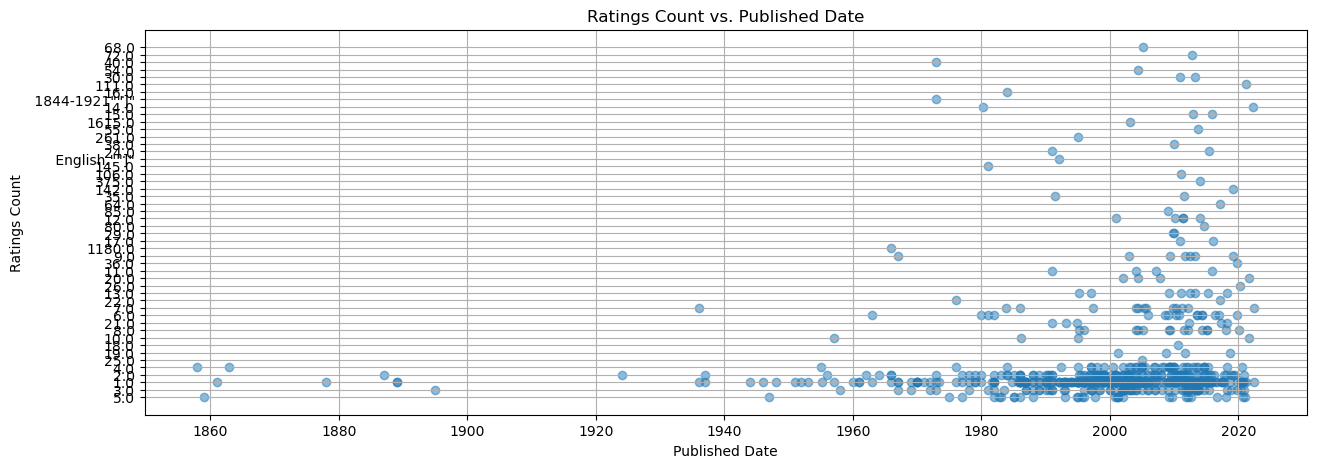

In [7]:
sample_df = df.select("publishedDate", "ratingsCount").dropna().limit(1000).toPandas()

sample_df['publishedDate'] = pd.to_datetime(sample_df['publishedDate'], errors='coerce')
sample_df = sample_df.dropna(subset=['publishedDate'])

plt.figure(figsize=(15, 5))
plt.scatter(sample_df['publishedDate'], sample_df['ratingsCount'], alpha=0.5)
plt.xlabel("Published Date")
plt.ylabel("Ratings Count")
plt.title("Ratings Count vs. Published Date")
plt.grid(True)
plt.show()

In [8]:
df.groupBy("publisher").count().orderBy("count", ascending=False).show(10)


+--------------------+-----+
|           publisher|count|
+--------------------+-----+
|                NULL|73130|
|  Simon and Schuster| 2947|
|             Penguin| 2304|
|           Routledge| 2149|
|   John Wiley & Sons| 1672|
|      Harper Collins| 1504|
|Cambridge Univers...| 1451|
|           Macmillan| 1059|
|     Open Road Media|  974|
| Courier Corporation|  967|
+--------------------+-----+
only showing top 10 rows



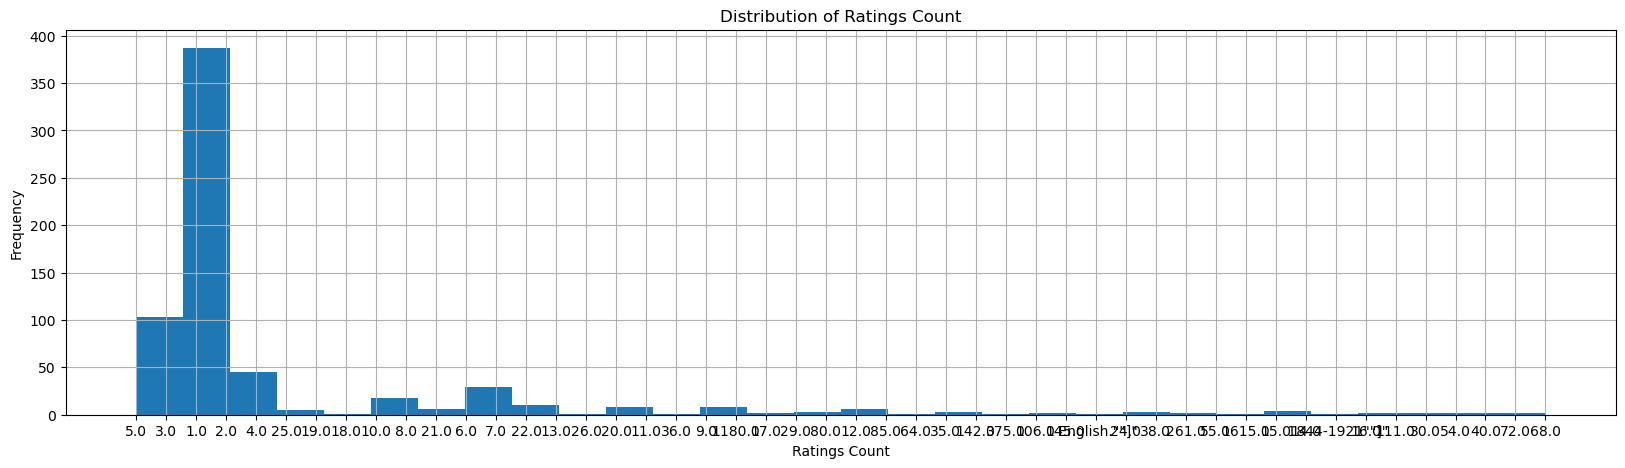

In [9]:
plt.figure(figsize=(20, 5))
sample_df['ratingsCount'].dropna().hist(bins=30)
plt.title("Distribution of Ratings Count")
plt.xlabel("Ratings Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


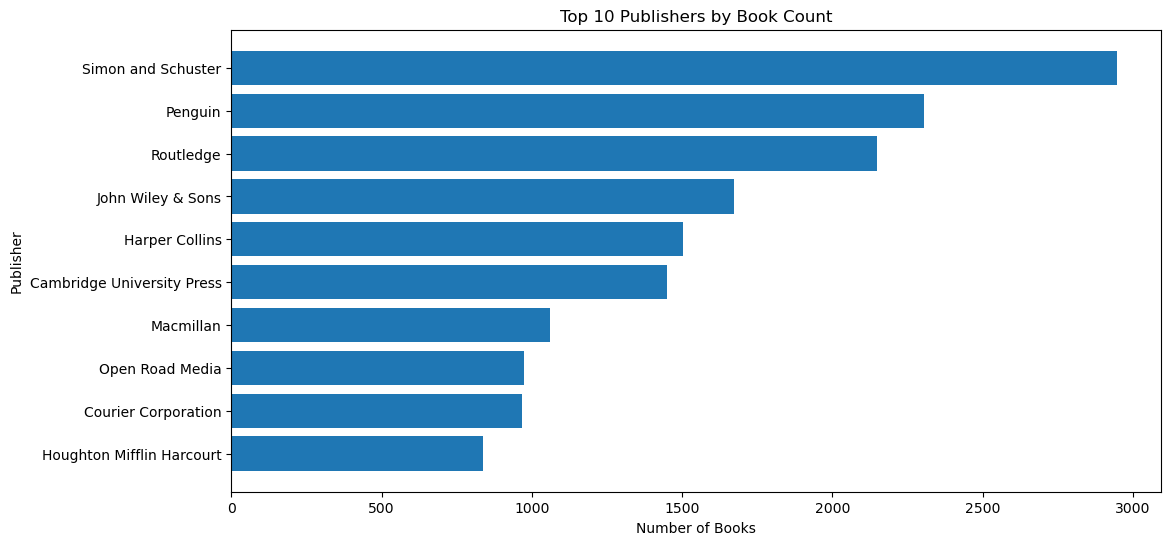

In [10]:
top_publishers = (
    df.filter(df.publisher.isNotNull())
      .groupBy("publisher")
      .count()
      .orderBy("count", ascending=False)
      .limit(10)
      .toPandas()
)

plt.figure(figsize=(12, 6))
plt.barh(top_publishers['publisher'], top_publishers['count'])
plt.title("Top 10 Publishers by Book Count")
plt.xlabel("Number of Books")
plt.ylabel("Publisher")
plt.gca().invert_yaxis()  
plt.show()



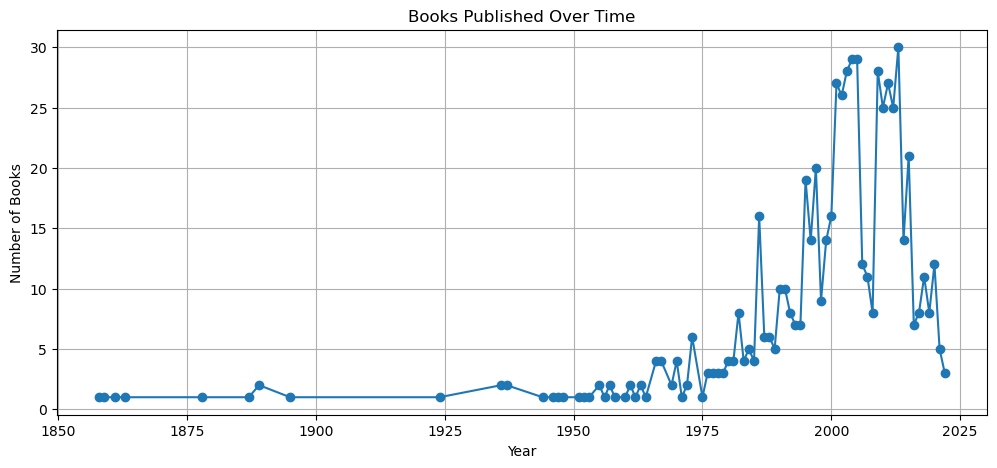

In [11]:

sample_df['year'] = pd.to_datetime(sample_df['publishedDate'], errors='coerce').dt.year
books_per_year = sample_df['year'].value_counts().sort_index()

plt.figure(figsize=(12, 5))
books_per_year.plot(kind='line', marker='o')
plt.title("Books Published Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Books")
plt.grid(True)
plt.show()


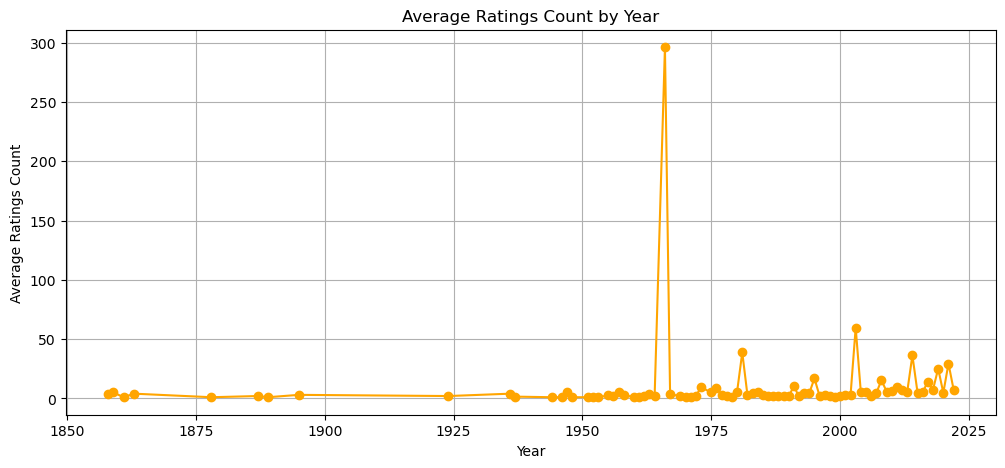

In [12]:

sample_df['ratingsCount'] = pd.to_numeric(sample_df['ratingsCount'], errors='coerce')
avg_ratings_by_year = sample_df.groupby('year')['ratingsCount'].mean().dropna()


plt.figure(figsize=(12, 5))
avg_ratings_by_year.plot(kind='line', marker='o', color='orange')
plt.title("Average Ratings Count by Year")
plt.xlabel("Year")
plt.ylabel("Average Ratings Count")
plt.grid(True)
plt.show()



EDA for Books_rating aka df1

In [13]:
df1.columns

['Id',
 'Title',
 'Price',
 'User_id',
 'profileName',
 'review/helpfulness',
 'review/score',
 'review/time',
 'review/summary',
 'review/text']

In [14]:
df1.printSchema()
df1.show(5, truncate=False)


root
 |-- Id: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- User_id: string (nullable = true)
 |-- profileName: string (nullable = true)
 |-- review/helpfulness: string (nullable = true)
 |-- review/score: string (nullable = true)
 |-- review/time: string (nullable = true)
 |-- review/summary: string (nullable = true)
 |-- review/text: string (nullable = true)

+----------+------------------------------+-----+--------------+--------------------------------------+------------------+------------+-----------+-----------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [15]:
df1.select("Price", "review/score").describe().show()


+-------+--------------------+------------------+
|summary|               Price|      review/score|
+-------+--------------------+------------------+
|  count|              482421|           2999870|
|   mean|  21.767951161877054| 1656.860421970827|
| stddev|   26.21155241772817|1427549.9863179324|
|    min|              "" and|   & Algorithms"""|
|    max|: A guide to loca...|         thersites|
+-------+--------------------+------------------+



In [16]:

df1 = df1.withColumn("Price", col("Price").cast("float"))
quantiles = df1.approxQuantile("Price", [0.25, 0.5, 0.75], 0.05)
print(f"Approximate Quantiles for Price: {quantiles}")

Approximate Quantiles for Price: [10.319999694824219, 14.020000457763672, 21.950000762939453]


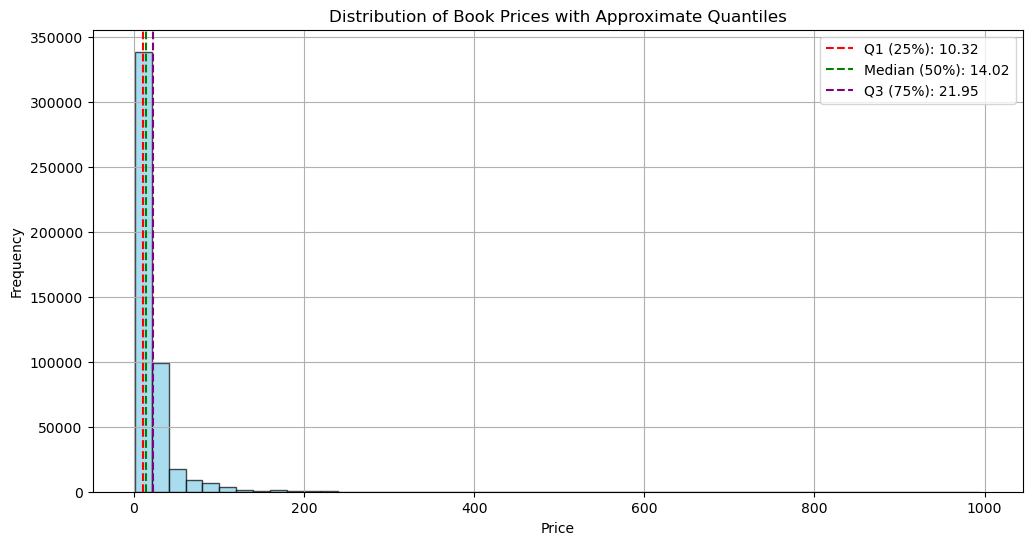

In [17]:

price_pd = df1.select("Price").dropna().toPandas()


plt.figure(figsize=(12, 6))
plt.hist(price_pd["Price"], bins=50, color='skyblue', edgecolor='black', alpha=0.7)


q1, q2, q3 = quantiles
plt.axvline(x=q1, color='red', linestyle='--', label=f'Q1 (25%): {q1:.2f}')
plt.axvline(x=q2, color='green', linestyle='--', label=f'Median (50%): {q2:.2f}')
plt.axvline(x=q3, color='purple', linestyle='--', label=f'Q3 (75%): {q3:.2f}')

plt.title("Distribution of Book Prices with Approximate Quantiles")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


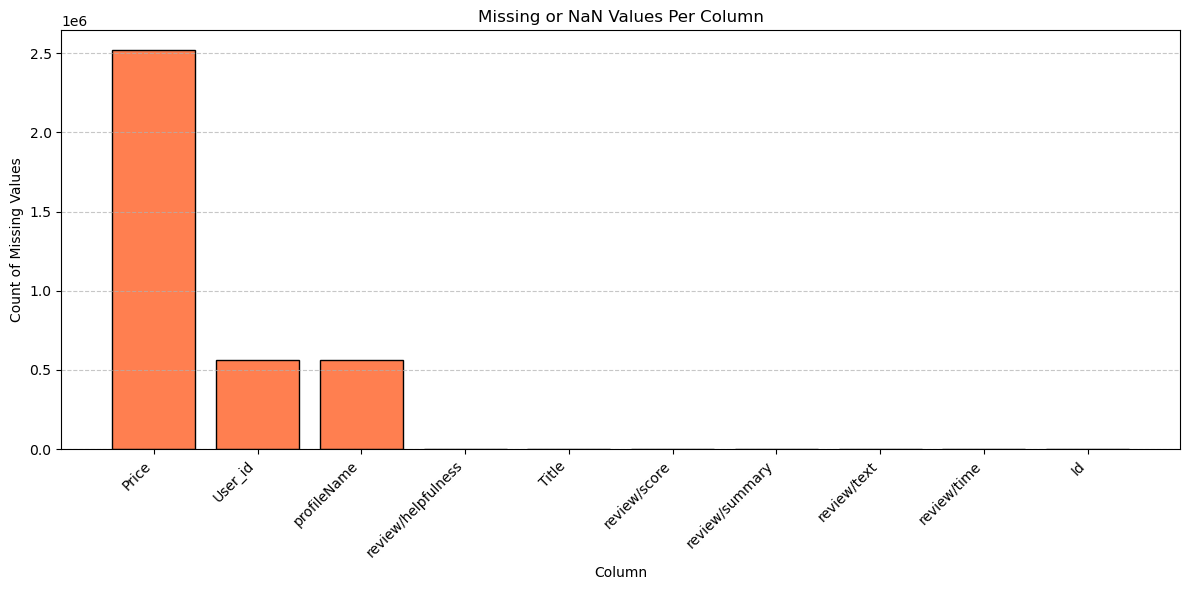

In [18]:

missing_df = df1.select([
    count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df1.columns
])


missing_pd = missing_df.toPandas().T.reset_index()
missing_pd.columns = ['Column', 'MissingCount']
missing_pd = missing_pd.sort_values(by='MissingCount', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(missing_pd['Column'], missing_pd['MissingCount'], color='coral', edgecolor='black')
plt.title("Missing or NaN Values Per Column")
plt.xlabel("Column")
plt.ylabel("Count of Missing Values")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


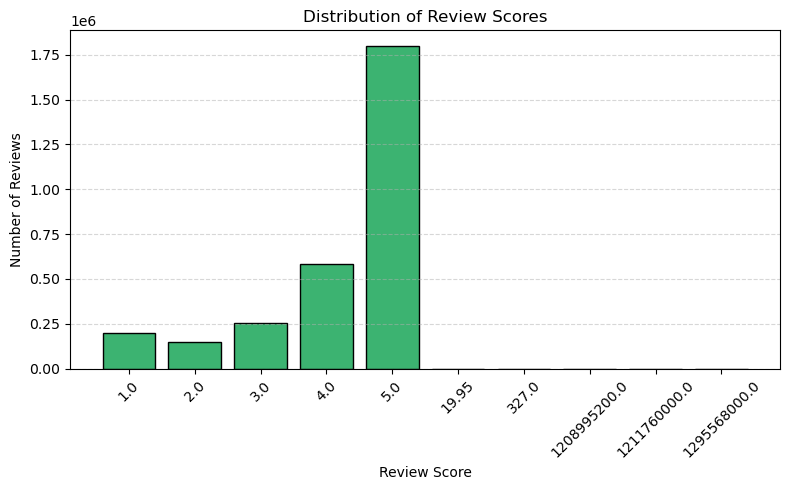

In [19]:
df1 = df1.withColumn("review/score", col("review/score").cast("float"))
score_counts = (
    df1.filter(col("review/score").isNotNull())
       .groupBy("review/score")
       .count()
       .orderBy("review/score")
       .toPandas()
)
plt.figure(figsize=(8, 5))
plt.bar(score_counts["review/score"].astype(str), score_counts["count"],
        color='mediumseagreen', edgecolor='black')
plt.title("Distribution of Review Scores")
plt.xlabel("Review Score")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



 Task 2: Data Cleaning & Processing in PySpark
(a) Missing Value Handling

In [20]:
from pyspark.sql.functions import col, when, count, isnan
df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c + "_nulls") for c in df.columns]).show()

# Drop rows where critical fields are missing
df = df.dropna(subset=["Title", "ratingsCount", "publishedDate"])

df = df.fillna({
    "authors": "Unknown",
    "publisher": "Unknown",
    "categories": "Uncategorized"
})
df = df.withColumn("ratingsCount", col("ratingsCount").cast("float"))
median_rating = df.approxQuantile("ratingsCount", [0.5], 0.01)[0]
df = df.fillna({"ratingsCount": median_rating})


+-----------+-----------------+-------------+-----------+-----------------+---------------+-------------------+--------------+----------------+------------------+
|Title_nulls|description_nulls|authors_nulls|image_nulls|previewLink_nulls|publisher_nulls|publishedDate_nulls|infoLink_nulls|categories_nulls|ratingsCount_nulls|
+-----------+-----------------+-------------+-----------+-----------------+---------------+-------------------+--------------+----------------+------------------+
|          1|            68357|        31251|      51191|            24055|          73130|              25844|         24301|           40524|            148552|
+-----------+-----------------+-------------+-----------+-----------------+---------------+-------------------+--------------+----------------+------------------+



In [21]:

Q1, Q3 = df.approxQuantile("ratingsCount", [0.25, 0.75], 0.05)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df.filter((col("ratingsCount") >= lower_bound) & (col("ratingsCount") <= upper_bound))


Q1: 1.0, Q3: 2.0, IQR: 1.0
Lower Bound: -0.5, Upper Bound: 3.5


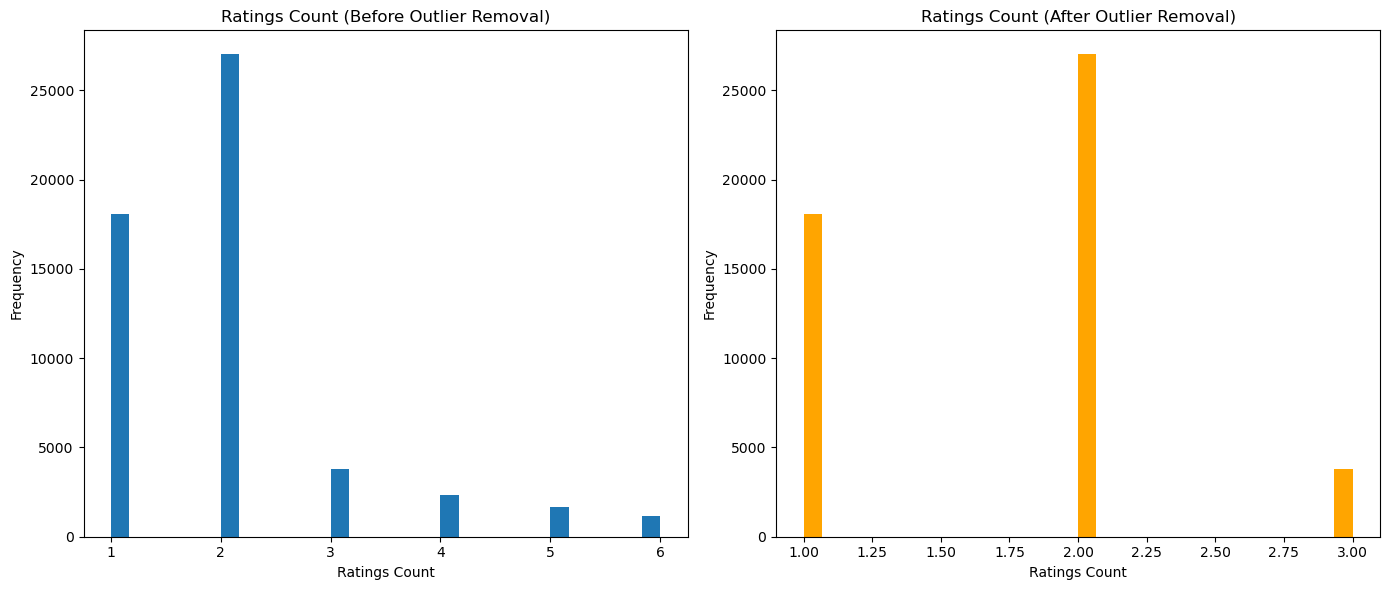

In [22]:
Q1, Q3 = df.approxQuantile("ratingsCount", [0.25, 0.75], 0.05)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

ratings_before = df.select("ratingsCount").toPandas()

df_filtered = df.filter((col("ratingsCount") >= lower_bound) & (col("ratingsCount") <= upper_bound))
ratings_after = df_filtered.select("ratingsCount").toPandas()
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(ratings_before['ratingsCount'].dropna(), bins=30)
plt.title("Ratings Count (Before Outlier Removal)")
plt.xlabel("Ratings Count")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(ratings_after['ratingsCount'].dropna(), bins=30, color='orange')
plt.title("Ratings Count (After Outlier Removal)")
plt.xlabel("Ratings Count")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [23]:
from pyspark.sql.functions import to_date
df = df.withColumn("publishedDate", to_date(col("publishedDate"), "yyyy-MM-dd"))
df = df.withColumn("ratingsCount", col("ratingsCount").cast("int"))


In [24]:
avg_ratings_by_category = df.groupBy("categories").avg("ratingsCount").orderBy("avg(ratingsCount)", ascending=False)
avg_ratings_by_category.show()


+--------------------+-----------------+
|          categories|avg(ratingsCount)|
+--------------------+-----------------+
|['Byrnes, Pete (F...|              6.0|
|         ['Revenge']|              6.0|
|['Curious George ...|              6.0|
|          ['Circle']|              6.0|
|      ['Daredevils']|              6.0|
|        ['Colombia']|              6.0|
|          ['Blacks']|              6.0|
|         ['Archers']|              6.0|
|['Dalziel, Andrew...|              6.0|
|['Crime and crimi...|              6.0|
|['Akenfield (Engl...|              6.0|
|['Arts and crafts...|              6.0|
|['Self-realization']|              6.0|
|['Dee Jen-Djieh (...|              6.0|
|['Pompeii (Extinc...|              6.0|
|       ['Empresses']|              6.0|
|      ['Detectives']|              6.0|
|['Oz (Imaginary p...|              6.0|
|['Eiger (Switzerl...|              6.0|
|           ['Songs']|              6.0|
+--------------------+-----------------+
only showing top

EDA for df2 i.e for Book_rating dataset

In [25]:
missing_df1 = df1.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df1.columns])
missing_df1.show()

+---+-----+-------+-------+-----------+------------------+------------+-----------+--------------+-----------+
| Id|Title|  Price|User_id|profileName|review/helpfulness|review/score|review/time|review/summary|review/text|
+---+-----+-------+-------+-----------+------------------+------------+-----------+--------------+-----------+
|  0|  208|2519269| 562250|     562250|               367|       18064|         27|            65|         43|
+---+-----+-------+-------+-----------+------------------+------------+-----------+--------------+-----------+



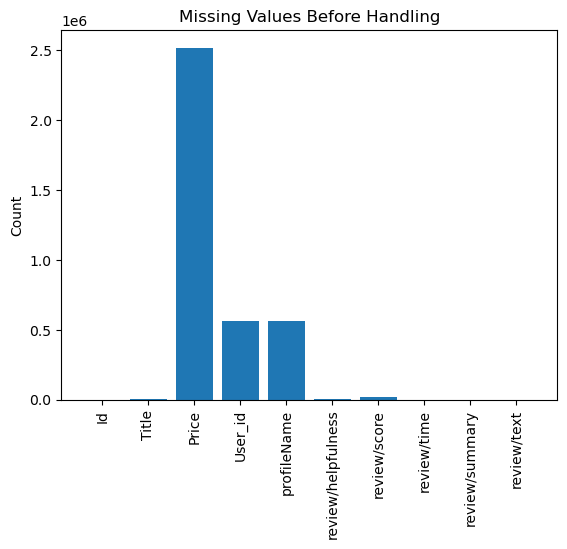

In [26]:
missing_pd1 = missing_df1.toPandas().T.reset_index()
missing_pd1.columns = ["column", "missing_count"]
plt.bar(missing_pd1["column"], missing_pd1["missing_count"])
plt.xticks(rotation=90)
plt.title("Missing Values Before Handling")
plt.ylabel("Count")
plt.show()


In [27]:
from pyspark.sql.functions import lit
median_price = df1.approxQuantile("Price", [0.5], 0.001)[0]
df1 = df1.fillna({"Price": median_price})
df1 = df1.fillna({"profileName": "Unknown"})
df1 = df1.dropna(subset=["review/text"])


In [28]:
q1, q3 = df1.approxQuantile("Price", [0.25, 0.75], 0.05)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = df1.filter((col("Price") < lower_bound) | (col("Price") > upper_bound))
print(f"Outlier Count: {outliers.count()}")


Outlier Count: 479259


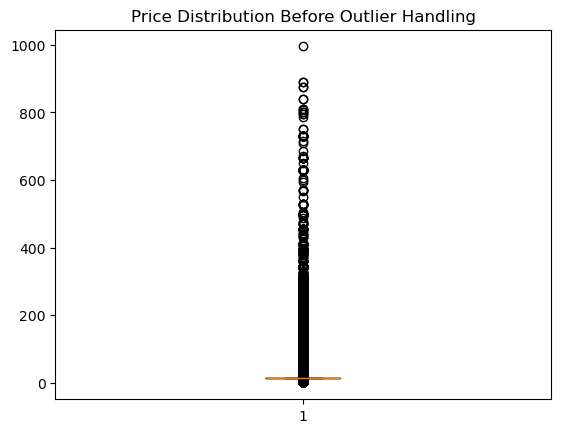

In [29]:
price_pd_before = df1.select("Price").toPandas()
plt.boxplot(price_pd_before["Price"])
plt.title("Price Distribution Before Outlier Handling")
plt.show()


In [30]:
df1 = df1.withColumn("Price", when(col("Price") > upper_bound, upper_bound)
                                .when(col("Price") < lower_bound, lower_bound)
                                .otherwise(col("Price")))


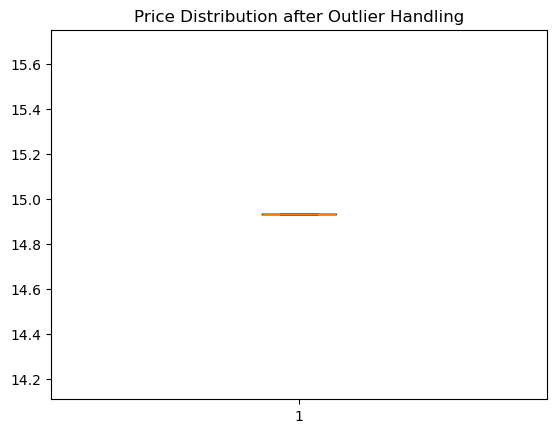

In [31]:
price_pd_after = df1.select("Price").toPandas()
plt.boxplot(price_pd_after["Price"])
plt.title("Price Distribution after Outlier Handling")
plt.show()

In [32]:
from pyspark.sql.functions import from_unixtime
df1 = df1.withColumn("Price", col("Price").cast("float")) \
         .withColumn("review/score", col("review/score").cast("float")) \
         .withColumn("review_date", from_unixtime("review/time").cast("date"))


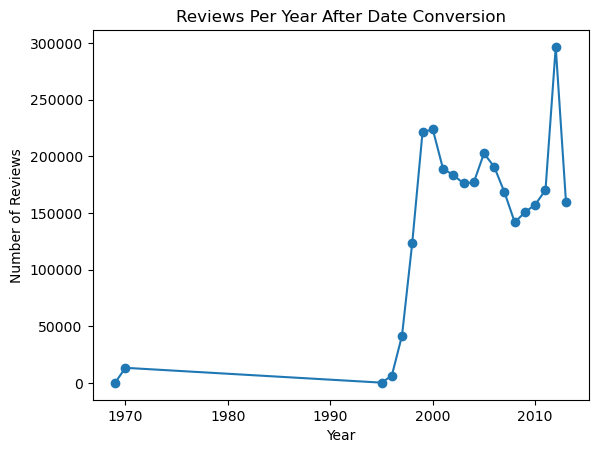

In [33]:
from pyspark.sql.functions import year

review_years = df1.withColumn("year", year("review_date")) \
                  .groupBy("year").count() \
                  .orderBy("year")

review_years_pd = review_years.toPandas()

plt.plot(review_years_pd["year"], review_years_pd["count"], marker='o')
plt.title("Reviews Per Year After Date Conversion")
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.show()


In [34]:
avg_price_score = df1.groupBy("review/score").avg("Price").orderBy("review/score")
avg_price_score.show()
reviewer_counts = df1.groupBy("profileName").count().orderBy(col("count").desc())
reviewer_counts.show(5)


+------------+------------------+
|review/score|        avg(Price)|
+------------+------------------+
|        NULL|14.930000305175781|
|         1.0|14.930000305175781|
|         2.0|14.930000305175781|
|         3.0|14.930000305175781|
|         4.0|14.930000305175781|
|         5.0|14.930000305175781|
|       19.95|14.930000305175781|
|       327.0|14.930000305175781|
|  1.295568E9|14.930000305175781|
+------------+------------------+

+--------------------+------+
|         profileName| count|
+--------------------+------+
|             Unknown|562405|
| Midwest Book Review|  5813|
|          A Customer|  5014|
|    Harriet Klausner|  3606|
|"E. A Solinas ""e...|  3145|
+--------------------+------+
only showing top 5 rows



In [35]:
df1.printSchema()
df.printSchema()

df_merged = df1.join(df, on="Title", how="left")
df_merged.printSchema()

root
 |-- Id: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Price: float (nullable = false)
 |-- User_id: string (nullable = true)
 |-- profileName: string (nullable = false)
 |-- review/helpfulness: string (nullable = true)
 |-- review/score: float (nullable = true)
 |-- review/time: string (nullable = true)
 |-- review/summary: string (nullable = true)
 |-- review/text: string (nullable = true)
 |-- review_date: date (nullable = true)

root
 |-- Title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- authors: string (nullable = false)
 |-- image: string (nullable = true)
 |-- previewLink: string (nullable = true)
 |-- publisher: string (nullable = false)
 |-- publishedDate: date (nullable = true)
 |-- infoLink: string (nullable = true)
 |-- categories: string (nullable = false)
 |-- ratingsCount: integer (nullable = true)

root
 |-- Title: string (nullable = true)
 |-- Id: string (nullable = true)
 |-- Price: float (nullable = false)
 |-- 

In [42]:
from pyspark.sql import SparkSession

output_path = "hdfs://namenode:8020/user/jovyan/output/merged_books_data"

# Save merged_df as CSV with header
df_merged.write \
    .mode("overwrite") \
    .option("header", True) \
    .csv(output_path)

print(f"Merged DataFrame saved successfully to {output_path}")



Merged DataFrame saved successfully to hdfs://namenode:8020/user/jovyan/output/merged_books_data


3. Spark Machine learning

In [36]:
# Import Libraries
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.sql.functions import when, split

In [37]:
df_merged = df_merged.limit(5000)
df_merged = df_merged.withColumn("sentiment", when(df_merged["review/score"] >= 3, "Positive").otherwise("Negative"))

df_merged = df_merged.withColumn("helpfulness_num", split(df_merged["review/helpfulness"], "/").getItem(0).cast("float"))
df_merged = df_merged.withColumn("helpfulness_den", split(df_merged["review/helpfulness"], "/").getItem(1).cast("float"))
df_merged = df_merged.withColumn("helpfulness_ratio", (df_merged["helpfulness_num"] / df_merged["helpfulness_den"]))
df_merged = df_merged.withColumn("fake_label", when((df_merged["helpfulness_ratio"] < 0.3), "Fake").otherwise("Real"))


df_merged = df_merged.dropna(subset=["review/text", "review/score"])

columns_to_drop = [col_name for col_name in df_merged.columns if col_name not in ["review/text", "sentiment", "review/score", "review/helpfulness", "helpfulness_num", "helpfulness_den", "helpfulness_ratio", "fake_label"]]
df_merged = df_merged.drop(*columns_to_drop)


tokenizer = Tokenizer(inputCol="review/text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=1000)
idf = IDF(inputCol="rawFeatures", outputCol="features")


(trainingData, testData) = df_merged.randomSplit([0.8, 0.2], seed=42)

sentiment_label_indexer = StringIndexer(inputCol="sentiment", outputCol="label")


sentiment_pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, sentiment_label_indexer])

sentiment_model = sentiment_pipeline.fit(trainingData)
train_sentiment = sentiment_model.transform(trainingData)
test_sentiment = sentiment_model.transform(testData)


lr_sentiment = LogisticRegression(featuresCol='features', labelCol='label')
lr_sentiment_model = lr_sentiment.fit(train_sentiment)
predictions_sentiment = lr_sentiment_model.transform(test_sentiment)

sentiment_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
sentiment_accuracy = sentiment_evaluator.evaluate(predictions_sentiment)
print(f"Sentiment Analysis Test Accuracy = {sentiment_accuracy:.4f}")

# Hyperparameter Tuning
paramGrid_sentiment = ParamGridBuilder().addGrid(lr_sentiment.regParam, [0.01, 0.1, 1.0]).build()
tvs_sentiment = TrainValidationSplit(estimator=lr_sentiment,
                                     estimatorParamMaps=paramGrid_sentiment,
                                     evaluator=sentiment_evaluator,
                                     trainRatio=0.8)
best_sentiment_model = tvs_sentiment.fit(train_sentiment)
final_predictions_sentiment = best_sentiment_model.transform(test_sentiment)
final_sentiment_accuracy = sentiment_evaluator.evaluate(final_predictions_sentiment)
print(f"Best Sentiment Model Accuracy = {final_sentiment_accuracy:.4f}")


Sentiment Analysis Test Accuracy = 0.7819
Best Sentiment Model Accuracy = 0.8662


In [45]:
from pyspark.sql import Row
import datetime
import builtins  # <-- important!!

metrics_data = [
    Row(
        timestamp=str(datetime.datetime.now()),
        sentiment_accuracy=builtins.round(sentiment_accuracy, 4),
        best_sentiment_accuracy=builtins.round(final_sentiment_accuracy, 4)
    )
]

metrics_df = spark.createDataFrame(metrics_data)

metrics_output_path = "hdfs://namenode:8020/user/jovyan/output/sentiment_metrics"

metrics_df.write \
    .mode("overwrite") \
    .option("header", True) \
    .csv(metrics_output_path)

print(f"Metrics saved successfully to {metrics_output_path}")





Metrics saved successfully to hdfs://namenode:8020/user/jovyan/output/sentiment_metrics


In [39]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

trainingData = trainingData.withColumn("label", col("review/score").cast("float"))
testData = testData.withColumn("label", col("review/score").cast("float"))

rating_pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf])


rating_model = rating_pipeline.fit(trainingData)
train_rating = rating_model.transform(trainingData)
test_rating = rating_model.transform(testData)


lr_rating = LinearRegression(featuresCol='features', labelCol='label')
lr_rating_model = lr_rating.fit(train_rating)
predictions_rating = lr_rating_model.transform(test_rating)


rating_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rating_rmse = rating_evaluator.evaluate(predictions_rating)
print(f"Rating Prediction RMSE = {rating_rmse:.4f}")

Rating Prediction RMSE = 1.3751


In [40]:
mae_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
r2_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
mae = mae_evaluator.evaluate(predictions_rating)
r2 = r2_evaluator.evaluate(predictions_rating)

print(f"  MAE  = {mae:.4f}")
print(f"  R²   = {r2:.4f}")

  MAE  = 1.0265
  R²   = -0.2139


In [46]:
from pyspark.sql import Row
import datetime
import builtins  # <-- important to use Python's round, not PySpark's

rating_metrics_data = [
    Row(
        timestamp=str(datetime.datetime.now()),
        rating_rmse=builtins.round(rating_rmse, 4),
        rating_mae=builtins.round(mae, 4),
        rating_r2=builtins.round(r2, 4)
    )
]

rating_metrics_df = spark.createDataFrame(rating_metrics_data)

rating_metrics_output_path = "hdfs://namenode:8020/user/jovyan/output/rating_prediction_metrics"

rating_metrics_df.write \
    .mode("overwrite") \
    .option("header", True) \
    .csv(rating_metrics_output_path)

print(f"Rating prediction metrics saved successfully to {rating_metrics_output_path}")



Rating prediction metrics saved successfully to hdfs://namenode:8020/user/jovyan/output/rating_prediction_metrics


In [41]:
(trainingData_fake, testData_fake) = df_merged.randomSplit([0.8, 0.2], seed=42)
fake_label_indexer = StringIndexer(inputCol="fake_label", outputCol="label")

fake_pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, fake_label_indexer])

fake_model1 = fake_pipeline.fit(trainingData_fake)
train_fake = fake_model1.transform(trainingData_fake)
test_fake = fake_model1.transform(testData_fake)

rf_fake = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=50)
rf_fake_model = rf_fake.fit(train_fake)
predictions_fake = rf_fake_model.transform(test_fake)

evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
fake_accuracy = evaluator_accuracy.evaluate(predictions_fake)

print(f"Fake Review Detection Accuracy = {fake_accuracy:.4f}")

paramGrid_fake = ParamGridBuilder().addGrid(rf_fake.numTrees, [30, 50, 100]).build()

tvs_fake = TrainValidationSplit(estimator=rf_fake,
                                estimatorParamMaps=paramGrid_fake,
                                evaluator=evaluator_accuracy,
                                trainRatio=0.8)

best_fake_model = tvs_fake.fit(train_fake)
final_predictions_fake = best_fake_model.transform(test_fake)

final_fake_accuracy = evaluator_accuracy.evaluate(final_predictions_fake)
print(f"Best Fake Review Model Accuracy = {final_fake_accuracy:.4f}")



Fake Review Detection Accuracy = 0.9041
Best Fake Review Model Accuracy = 0.9041


In [ ]:
from pyspark.sql import Row
import datetime

fake_metrics_data = [
    Row(
        timestamp=str(datetime.datetime.now()),
        fake_detection_accuracy=round(fake_accuracy, 4),
        best_fake_detection_accuracy=round(final_fake_accuracy, 4)
    )
]

fake_metrics_df = spark.createDataFrame(fake_metrics_data)
fake_metrics_output_path = "hdfs://namenode:8020/output/fake_review_detection_metrics"

fake_metrics_df.write \
    .mode("overwrite") \
    .option("header", True) \
    .csv(fake_metrics_output_path)

print(f"Fake Review Detection metrics saved successfully to {fake_metrics_output_path}")

